# Spatial join

[Spatial join](http://wiki.gis.com/wiki/index.php/Spatial_Join) is
yet another classic GIS problem. Getting attributes from one layer and
transferring them into another layer based on their spatial relationship
is something you most likely need to do on a regular basis.

In the previous section we learned how to perform **a Point in Polygon query**.
We could now apply those techniques and create our own function to perform **a spatial join** between two layers based on their
spatial relationship. We could, for example, join the attributes of a polygon layer into a point layer where each point would get the
attributes of a polygon that ``contains`` the point.

Luckily, [spatial join is already implemented in Geopandas](http://geopandas.org/mergingdata.html#spatial-joins), thus we do not need to create our own function for doing it. There are three possible types of
join that can be applied in spatial join that are determined with ``op`` -parameter in the ``gpd.sjoin()`` -function:

-  ``"intersects"``
-  ``"within"``
-  ``"contains"``

Sounds familiar? Yep, all of those spatial relationships were discussed
in the [Point in Polygon lesson](point-in-polygon.ipynb), thus you should know how they work. 

Furthermore, pay attention to the different options for the type of join via the `how` parameter; "left", "right" and "inner". You can read more about these options in the [geopandas sjoin documentation](http://geopandas.org/mergingdata.html#sjoin-arguments) and pandas guide for [merge, join and concatenate](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)

Let's perform a spatial join between these two layers:
- **Addresses:** the geocoded address-point (we created this Shapefile in the geocoding tutorial)
- **Population grid:** 250m x 250m grid polygon layer that contains population information from the Helsinki Region.
    - The population grid a dataset is produced by the **Helsinki Region Environmental
Services Authority (HSY)** (see [this page](https://www.hsy.fi/fi/asiantuntijalle/avoindata/Sivut/AvoinData.aspx?dataID=7) to access data from different years).
    - You can download the data from [from this link](https://www.hsy.fi/sites/AvoinData/AvoinData/SYT/Tietoyhteistyoyksikko/Shape%20(Esri)/V%C3%A4est%C3%B6tietoruudukko/Vaestotietoruudukko_2018_SHP.zip) in the  [Helsinki Region Infroshare
(HRI) open data portal](https://hri.fi/en_gb/).



- Here, we will access the data directly from the HSY wfs:



In [2]:
import geopandas as gpd
from pyproj import CRS
import requests
import geojson

# # Specify the url for web feature service
# url = 'https://kartta.hsy.fi/geoserver/wfs' # URL NOT WORKING - CHECK AGAIN LATER

# # Specify parameters (read data in json format). 
# # Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
# params = dict(service='WFS', 
#               version='2.0.0', 
#               request='GetFeature', 
#               typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
#               outputFormat='json')

# # Fetch data from WFS using requests
# r = requests.get(url, params=params)

# # Create GeoDataFrame from geojson
# pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

LET'S READ THE DATA FROM THE DOWNLOADED SHAPEFILE

In [4]:
# Read file from Shapefile
fc = 'data/Vaestoruudukko_2018.shp'

# Create GeoDataFrame from Shapefile
pop = gpd.read_file(fc)

- Check the result: 

In [5]:
pop.head()

,INDEX,ASUKKAITA,ASVALJYYS,IKA0_9,IKA10_19,IKA20_29,IKA30_39,IKA40_49,IKA50_59,IKA60_69,IKA70_79,IKA_YLI80,geometry
0,688,9,28.0,99,99,99,99,99,99,99,99,99,"POLYGON Z ((25472499.995 6689749.005 0.000, 25..."
1,703,5,51.0,99,99,99,99,99,99,99,99,99,"POLYGON Z ((25472499.995 6685998.998 0.000, 25..."
2,710,8,44.0,99,99,99,99,99,99,99,99,99,"POLYGON Z ((25472499.995 6684249.004 0.000, 25..."
3,711,5,90.0,99,99,99,99,99,99,99,99,99,"POLYGON Z ((25472499.995 6683999.005 0.000, 25..."
4,715,11,41.0,99,99,99,99,99,99,99,99,99,"POLYGON Z ((25472499.995 6682998.998 0.000, 25..."


Okey so we have multiple columns in the dataset but the most important
one here is the column `asukkaita` ("population" in Finnish) that
tells the amount of inhabitants living under that polygon.

-  Let's change the name of that column into `pop18` so that it is
   more intuitive. As you might remember, we can easily rename (Geo)DataFrame column names using the ``rename()`` function where we pass a dictionary of new column names like this: ``columns={'oldname': 'newname'}``.

In [11]:
# re-name column name
cols={'ASUKKAITA': 'pop18'}
# Change the name of a column
pop = pop.rename(columns=cols)

# See the column names and confirm that we now have a column called 'pop17'
pop.columns

Index(['pop18', 'geometry'], dtype='object')

-  Let's also get rid of all unnecessary columns by selecting only
   columns that we need i.e. ``pop18`` and ``geometry``

In [12]:
# Subset columns
pop = pop[["pop18", "geometry"]]

In [13]:
pop.head()

,pop18,geometry
0,9,"POLYGON Z ((25472499.995 6689749.005 0.000, 25..."
1,5,"POLYGON Z ((25472499.995 6685998.998 0.000, 25..."
2,8,"POLYGON Z ((25472499.995 6684249.004 0.000, 25..."
3,5,"POLYGON Z ((25472499.995 6683999.005 0.000, 25..."
4,11,"POLYGON Z ((25472499.995 6682998.998 0.000, 25..."


Now we have cleaned the data and have only those columns that we need
for our analysis.

## Join the layers

Now we are ready to perform the spatial join between the two layers that
we have. The aim here is to get information about **how many people live
in a polygon that contains an individual address-point** . Thus, we want
to join attributes from the population layer we just modified into the
addresses point layer ``addresses.shp`` that we created trough gecoding in the previous section.

-  Read the addresses layer into memory:

In [14]:
# Addresses filpath
addr_fp = r"data/addresses.shp"

# Read data
addresses = gpd.read_file(addr_fp)

In [15]:
# Check the head of the file
addresses.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97783 60.18892)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


In order to do a spatial join, the layers need to be in the same projection

- Check the crs of input layers:

In [26]:
addresses.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
pop.crs

<Projected CRS: EPSG:3879>
Name: ETRS89 / GK25FIN
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Finland - 24.5°E to 25.5°E onshore nominal
- bounds: (24.5, 59.94, 25.5, 68.9)
Coordinate Operation:
- name: Finland Gauss-Kruger zone 25
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

If the crs information is missing from the population grid, we can **define the coordinate reference system** as **ETRS GK-25 (EPSG:3879)** because we know what it is based on the [population grid metadata](https://hri.fi/data/dataset/vaestotietoruudukko). 

__It is always a GOOD PRACTICE to define the crs information to WKT format__

* CRS.from_epsg('EPSG_code').to_wkt()

In [37]:
# Define crs
pop.crs = CRS.from_epsg(3879).to_wkt()

In [38]:
pop.crs

<Projected CRS: EPSG:3879>
Name: ETRS89 / GK25FIN
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Finland - 24.5°E to 25.5°E onshore nominal
- bounds: (24.5, 59.94, 25.5, 68.9)
Coordinate Operation:
- name: Finland Gauss-Kruger zone 25
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [39]:
# Are the layers in the same projection?
addresses.crs == pop.crs

False

Let's re-project addresses to the projection of the population layer:

In [40]:
addresses = addresses.to_crs(pop.crs)

-  Let's make sure that the coordinate reference system of the layers
are identical

In [44]:
# Check the crs of address points
print(f'Addres CRS infomation:\n{addresses.crs}\n')

# Check the crs of population layer
print(f'pop CRS infomation:\n{pop.crs}')

# Do they match now?
addresses.crs == pop.crs

Addres CRS infomation:
PROJCRS["ETRS89 / GK25FIN",BASEGEOGCRS["ETRS89",DATUM["European Terrestrial Reference System 1989",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["Finland Gauss-Kruger zone 25",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",25,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",1,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",25500000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["northing (N)",north,ORDER[1],LENGTHUNIT["metre",1]],AXIS["easting (E)",east,ORDER[2],LENGTHUNIT["metre",1]],USAGE[SCOPE["unknown"],AREA["Finland - 24.5°E to 25.5°E onshore nominal"],BBOX[59.94,24.5,68.

True

Now they should be identical. Thus, we can be sure that when doing spatial
queries between layers the locations match and we get the right results
e.g. from the spatial join that we are conducting here.

-  Let's now join the attributes from ``pop`` GeoDataFrame into
   ``addresses`` GeoDataFrame by using ``gpd.sjoin()`` -function:

In [46]:
# Make a spatial join
join = gpd.sjoin(addresses, pop, how="inner", op="within")

In [47]:
join.head()

,address,id,addr,geometry,index_right,pop18
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (25495311.608 6672258.695),3252,515
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (25496207.840 6672906.173),3364,182
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (25496768.622 6673002.004),3488,38
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (25498769.713 6675121.127),3822,61
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (25495645.995 6671528.068),3298,1435


Awesome! Now we have performed a successful spatial join where we got
two new columns into our ``join`` GeoDataFrame, i.e. ``index_right``
that tells the index of the matching polygon in the population grid and
``pop18`` which is the population in the cell where the address-point is
located.

- Let's still check how many rows of data we have now:

In [48]:
len(join)

30

Did we lose some data here? 

- Check how many addresses we had originally:

In [49]:
len(addresses)

34

If we plot the layers on top of each other, we can observe that some of the points are located outside the populated grid squares (increase figure size if you can't see this properly!)

<AxesSubplot:>

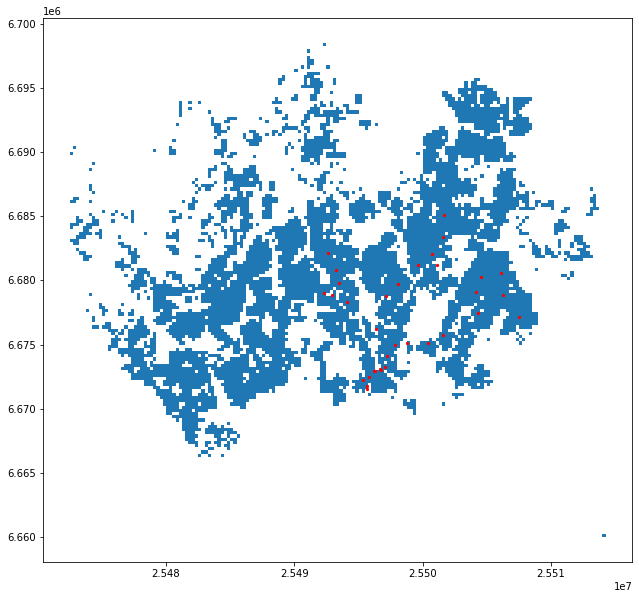

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# Plot population grid
pop.plot(ax=ax)

# Plot points
addresses.plot(ax=ax, color='red', markersize=5)

Let's also visualize the joined output:

-  Plot the points and use the ``pop18`` column to indicate the color.
   ``cmap`` -parameter tells to use a sequential colormap for the
   values, ``markersize`` adjusts the size of a point, ``scheme`` parameter can be used to adjust the classification method based on [pysal](http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html), and ``legend`` tells that we want to have a legend:


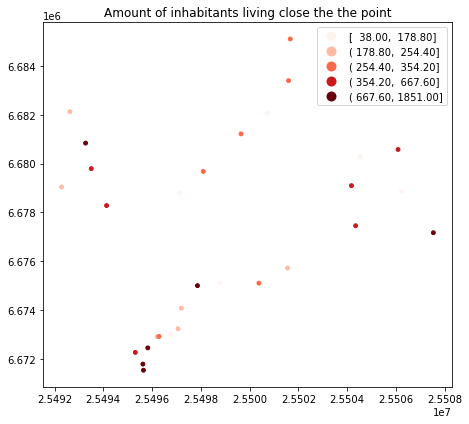

In [51]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10,6))

# Plot the points with population info
join.plot(ax=ax, column='pop18', cmap="Reds", markersize=15, scheme='quantiles', legend=True);

# Add title
plt.title("Amount of inhabitants living close the the point");

# Remove white space around the figure
plt.tight_layout()

In a similar way, we can plot the original population grid and check the overall population distribution in Helsinki:

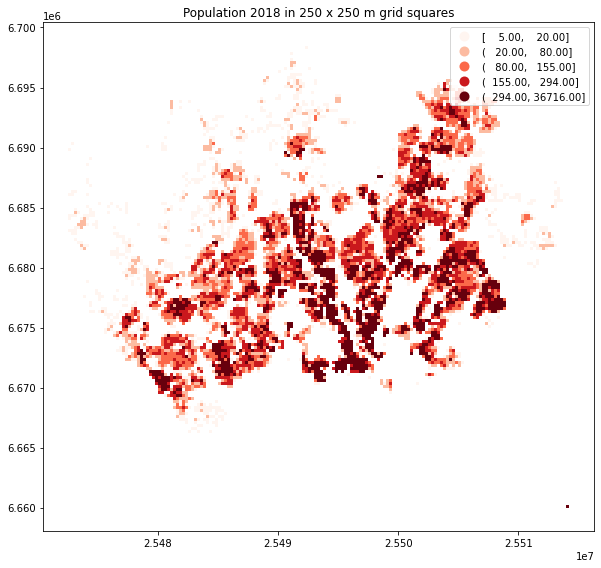

In [54]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(15,8))

# Plot the grid with population info
pop.plot(ax=ax, column='pop18', cmap="Reds", scheme='quantiles', legend=True);

# Add title
plt.title("Population 2018 in 250 x 250 m grid squares");

# Remove white space around the figure
plt.tight_layout()

-  Finally, let's save the result point layer into a file:

In [55]:
# Output path
outfp = r"data/addresses_population.shp"

# Save to disk
join.to_file(outfp)